# COMP5318 Assignment 2: Image Classification

### Group number: 100, SID1: 490576560, SID2: 520653377 

## Setup and dependencies
All the required libraries/dependencies and the plotting environment are listed and set up here.

In [1]:
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Make the notebook's output stable across runs.
# Random seed is set to 0 consistently.
np.random.seed(0)
tf.random.set_seed(0)
keras.backend.clear_session()

## 1. Data loading, preprocessing, and exploration
The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

### 1.1 Load data and declare variables

In [2]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train_original, y_train_original), (X_test_original, y_test_original) = keras.datasets.fashion_mnist.load_data()
assert X_train_original.shape == (60000, 28, 28)
assert X_test_original.shape == (10000, 28, 28)
assert y_train_original.shape == (60000,)
assert y_test_original.shape == (10000,)

# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

# Declare size of the image
IMAGE_SIZE = X_train_original[0].shape

### 1.2 Data processing

In [3]:
# Normalise data
X_train_full = X_train_original.reshape(X_train_original.shape[0], -1) # Flatten data from 3D to 2D
y_train_full = y_train_original.copy()
X_test = X_test_original.reshape(X_test_original.shape[0], -1) # Flatten data from 3D to 2D
y_test = y_test_original.copy()

scaler = MinMaxScaler()
scaler.fit(X_train_full)
X_train_full = scaler.transform(X_train_full) # apply normalisation to the training set
X_test = scaler.transform(X_test) # apply normalisation to the test set

X_train_full = X_train_full.reshape(X_train_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D
X_test = X_test.reshape(X_test_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D

# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9, stratify=y_train_full)

### 1.3 Data exploration

In [4]:
print(f"The original training set is {X_train_original.shape[0]} images with {X_train_original[0].shape} pixels, \
without normalization ({X_train_original.dtype}).")
print(f"The original test set is {X_test_original.shape[0]} images with {X_test_original[0].shape} pixels, \
without normalization ({X_test_original.dtype}).\n")

print(f"The size of training set is {X_train.shape[0]} ({X_train.dtype}), \
the size of validation set is {X_valid.shape[0]} ({X_valid.dtype}), and\
the size of test set is {X_test.shape[0]} ({X_test.dtype})")

The original training set is 60000 images with (28, 28) pixels, without normalization (uint8).
The original test set is 10000 images with (28, 28) pixels, without normalization (uint8).

The size of training set is 54000 (float64), the size of validation set is 6000 (float64), andthe size of test set is 10000 (float64)


In [5]:
def show_distribution(y):
    """Simple way to show a label distribution."""
    result = []
    for i in range(len(class_names)):
        result.append((y == i).sum())
    return result

print(f"There are {len(set(y_train_original))} different classes: {np.unique(y_train_original)}")
print(f"The label distribution of training set is {show_distribution(y_train)}")
print(f"The label distribution of validation set is {show_distribution(y_valid)}")
print(f"The label distribution of test set is {show_distribution(y_test)}")

There are 10 different classes: [0 1 2 3 4 5 6 7 8 9]
The label distribution of training set is [5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400]
The label distribution of validation set is [600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
The label distribution of test set is [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Some examples:


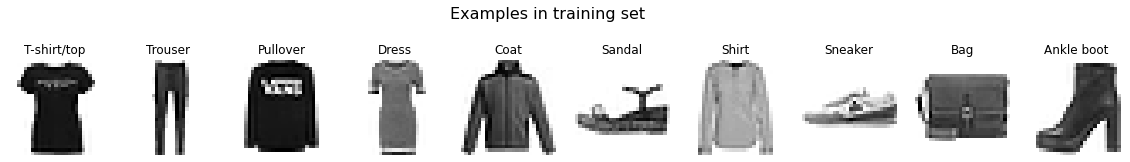

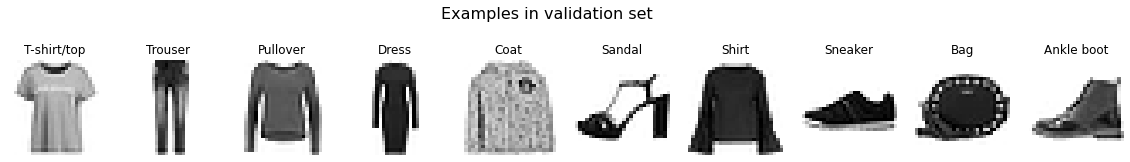

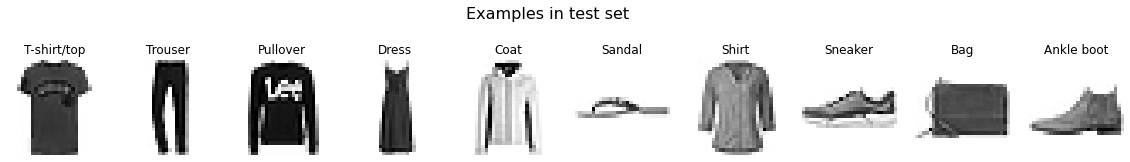

In [6]:
def plot_examples(X, y, title=""):
    """Plot a grid of images from different classes."""
    # Size figure depending on the size of the grid
    plt.figure(figsize=(20, 2))
    plt.suptitle(title, fontsize=16,x=0.5,y=1.2,)

    index = []
    # search index
    for i in range(len(class_names)):
        for j in range(len(y)):
            if i == y[j]:
                index.append(j)
                break

    # Plot the image at appropriate place in grid
    for i in range(len(index)):
        plt.subplot(1, len(index), i + 1)
        plt.imshow(X[index[i]], cmap="binary")
        plt.title(class_names[y[index[i]]])
        plt.axis('off')
            
    plt.show()

print("Some examples:")

plot_examples(X_train, y_train, "Examples in training set")
plot_examples(X_valid, y_valid, "Examples in validation set")
plot_examples(X_test, y_test, "Examples in test set")

## 2. Algorithm design and setup

### 2.1  K-nearest neighbors

First, A group of simple algorithms from the first 6 weeks are compared. They are: K-nearest neighbors, Naive Bayes, Decision tree, and Random forest. We simply train the model with default/simple parameters on the full training set, and test their accuracy.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=10) # k shoule be less than sqrt(#training_examples), commercial packages typically use k=10

# Training and timer
time_stamp = time.time()
neigh.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
neigh_training_time = time.time() - time_stamp

In [8]:
nb = GaussianNB()

# Training and timer
time_stamp = time.time()
nb.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
nb_training_time = time.time() - time_stamp

In [9]:
# Running in arround 30s

tree = DecisionTreeClassifier(criterion='entropy', random_state=0) # without setting max_depth results in overfitting.

# Training and timer
time_stamp = time.time()
tree.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
tree_training_time = time.time() - time_stamp

In [10]:
# Running in arround 90s

rnd = RandomForestClassifier(criterion='entropy', random_state=0) # n_estimators=100 by default

# Training and timer
time_stamp = time.time()
rnd.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
rnd_training_time = time.time() - time_stamp

In [11]:
print(f"The accuracy of KNN is {neigh.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {neigh_training_time:.2f} s.")
print(f"The accuracy of NB is {nb.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {nb_training_time:.2f} s.")
print(f"The accuracy of DT is {tree.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {tree_training_time:.2f} s.")
print(f"The accuracy of RF is {rnd.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {rnd_training_time:.2f} s.")

The accuracy of KNN is 0.8519, training time is 0.06 s.
The accuracy of NB is 0.5838, training time is 0.65 s.
The accuracy of DT is 0.8001, training time is 34.46 s.
The accuracy of RF is 0.8760, training time is 85.67 s.


Althouth Random Forest performs best, the training time is relatively long. Noticing that KNN is simple but with a content accuracy among them, the training time is  also tiny. Therefore, KNN is chosen.

### 2.2 Fully connected neural network

First, the numbers of layers need to be settled. Apart from the **input layer** and **output layer**, the numebr of hidden layer can be a variable. According to Cybenko(1998), any function (including discontinuous) can be approximated to arbitrary small error by a network with two hidden layers. To make the model small, we choose **two hidden layers**.

Number of neurons in the input layer: 784   
For numerical attributes, basically 1 neuron per attribute, in this dataset, we have 28 * 28 = 784 atttributes each example. Thus, the number of neurons of input layer should be 784. Simply, we just use **keras.layers.Flatten(input_shape)**

Number of neurons in the output layer: 10   
1 for each class. Therefore, the number of the output layers should be 10. The **softmax** function ($\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}$) converts the raw outputs of this layer into a probability distribution over the classes. 

Now we choose the hidden layers.   
**Sigmoid** is the most widely used transfer function.
We simply set most paras by default as well as the basic **SGD** learning algorithm. Since our labels are in index form rather than encoded as one-hot vectors, as we discussed earlier, we utilise the **sparse_categorical_crossentropy** loss. Then we observe the trend of the numbers of neurons with respect to MSE.

In [4]:
def test_build_mlp(num1=50, num2=50):
    """Build the MLP model with the specified number of neurons."""
    # Define a test MLP model
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=IMAGE_SIZE),
        keras.layers.Dense(num1, activation="sigmoid"),
        keras.layers.Dense(num2, activation="sigmoid"),
        keras.layers.Dense(len(class_names), activation="softmax")
    ])

    opt = keras.optimizers.SGD() # default learning_rate=0.01
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    # model.summary()
    return model

def test_train_mlp(num1, num2, max_epochs=50, criterion=0.02):
    """Training the model.
    max_epochs: the maximum number of epochs to terminate.
    criterion: stop when the difference between the loss of the last 5 epoch is less than."""
    # Train the classifier.
    mlp = test_build_mlp(num1, num2)
    loss_list = []
    for i in range(max_epochs):
        history = mlp.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1)
        loss_list.append(history.history["loss"][0])

        # Stop condition
        if len(loss_list) > 5 and loss_list[-6] - loss_list[-1] < criterion:
            print(len(loss_list))
            break
    
    return loss_list[-1], len(loss_list)

In [13]:
# Running in arround 960s

# some possible numbers to choose
hidden_layer_1 = [100, 200, 300, 400, 500, 600]

# results
loss_history_1 = []
epoch_history_1 = []

# for the first hidden layer
for i in hidden_layer_1:
    loss, epoch = test_train_mlp(i, 50)
    loss_history_1.append(loss)
    epoch_history_1.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4224 - accuracy: 0.8507 - val_loss: 0.4278 - val_accuracy: 0.8457
31
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4317 - accuracy: 0.8477 - val_loss: 0.4345 - val_accuracy: 0.8420
29
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4333 - accuracy: 0.8455 - val_loss: 0.4373 - val_accuracy: 0.8457
30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4385 - accuracy: 0.8451 - val_loss: 0.4431 - val_accuracy: 0.8403
28
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4412 - accuracy: 0.8437 - val_loss: 0.4447 - val_accuracy: 0.8380
27
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4392 - accuracy: 0.8460 - val_loss: 0.4385 - val_accuracy: 0.8405
27


In [14]:
loss_history_1 = [round(i, 4) for i in loss_history_1]
print(f"The min loss is {min(loss_history_1)} when neurons is equal to {hidden_layer_1[loss_history_1.index(min(loss_history_1))]}")

print(f"Loss history: {loss_history_1}")
print(f"Epoch history: {epoch_history_1}")

The min loss is 0.4224 when neurons is equal to 100
Loss history: [0.4224, 0.4317, 0.4333, 0.4385, 0.4412, 0.4392]
Epoch history: [31, 29, 30, 28, 27, 27]


It shows that when the number of neurons of the first layer is 100, the loss is minimal. Although the epochs is slightly larger, which may enhance the performance, the training time is much faster because of the lesser neurons. To keep the model small, we choose the 100 as the first number of neurons of the hidden layers.

In [15]:
# Running in arround 340s

# some possible numbers to choose
hidden_layer_2 = [20, 40, 60, 80]

# results
loss_history_2 = []
epoch_history_2 = []

# for the first hidden layer
for i in hidden_layer_2:
    loss, epoch = test_train_mlp(100, i)
    loss_history_2.append(loss)
    epoch_history_2.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4206 - accuracy: 0.8520 - val_loss: 0.4259 - val_accuracy: 0.8465
34
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4268 - accuracy: 0.8500 - val_loss: 0.4308 - val_accuracy: 0.8462
31
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4275 - accuracy: 0.8489 - val_loss: 0.4322 - val_accuracy: 0.8450
30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4236 - accuracy: 0.8495 - val_loss: 0.4268 - val_accuracy: 0.8465
31


In [16]:
loss_history_2 = [round(i, 4) for i in loss_history_2]
print(f"The min loss is {min(loss_history_2)} when neurons is equal to {hidden_layer_2[loss_history_2.index(min(loss_history_2))]}")

print(f"Loss history: {loss_history_2}")
print(f"Epoch history: {epoch_history_2}")

The min loss is 0.4206 when neurons is equal to 20
Loss history: [0.4206, 0.4268, 0.4275, 0.4236]
Epoch history: [34, 31, 30, 31]


We select 20 as the neurons of the second hidden layer using the same method as before consistently. 

### Convolutional neural network

## 3. Hyperparameter tuning

In [5]:
# Helper method in this section.
def get_result(estimator, paras, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=1):
    """get grid search result.
    estimator: model to be tuned.
    paras: an instance of ParameterGrid."""
    # Return a dict
    result = {
        "best_paras": None,
        "best_score": 0,
        "best_estimator": None,
        "results": [],
    }

    i = 0

    # Grid search for each combination.
    for para in paras:
        # Set para
        current_estimator = clone(estimator)
        current_estimator.set_params(**para)

        # Training and timer
        t1 = time.time()
        if epochs == 1:
            current_estimator.fit(X_train, y_train)
        else:
            current_estimator.fit(X_train, y_train, epochs=epochs)
        t2 = time.time()

        # Score on validation set
        score = current_estimator.score(X_valid, y_valid)
        t3 = time.time()

        # result for each combination
        temp = {}
        temp["paras"] = para
        temp["training_time"] = t2 - t1
        temp["validation_time"] = t3 - t2
        temp["score"] =score
        
        # Update the best result
        result["results"].append(temp)
        if score > result["best_score"]:
            result["best_paras"] = para
            result["best_score"] = score
            result["best_estimator"] = current_estimator
        
        i += 1
        print(f"{i} out of {len(list(paras))} finished: {para}")

    return result

def show_results(name, result, X_test=X_test, y_test=y_test):
    """Show the results."""
    print(f"Results for {name}:")
    print("Best parameters: {}".format(result["best_paras"]))
    print("Best validation score: {:.4f}".format(result["best_score"]))
    print("Test set score: {:.4f}".format(result["best_estimator"].score(X_test, y_test)))

    # table of results
    df = pd.DataFrame(
        columns=["Score", "training_time", "validation_time"], 
        index=[str(result["results"][i]["paras"]) for i in range(len(result["results"]))]
        )

    for i in range(len(result["results"])):
        df.loc[str(result["results"][i]["paras"])] = [
            round(result["results"][i]["score"], 4),
            round(result["results"][i]["training_time"], 2),
            round(result["results"][i]["validation_time"], 2)
            ]

    df.to_csv(f'{name}_results.csv')
    display(df)

### 3.1 K-nearest neighbors

First, to determine a rough trend of the accuracy with different k, we calculate an accuracy every 10 with different k, until k = 245 (sqrt(#examples)), e.g., k = [1, 11, 21, ..., 241]

In [18]:
# Running in arroung 190s

k_value = [1 + i for i in range(245)]
k_acc = []

for i in k_value:
    if i % 10 != 1:
        continue
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 11	 finished.
k = 21	 finished.
k = 31	 finished.
k = 41	 finished.
k = 51	 finished.
k = 61	 finished.
k = 71	 finished.
k = 81	 finished.
k = 91	 finished.
k = 101	 finished.
k = 111	 finished.
k = 121	 finished.
k = 131	 finished.
k = 141	 finished.
k = 151	 finished.
k = 161	 finished.
k = 171	 finished.
k = 181	 finished.
k = 191	 finished.
k = 201	 finished.
k = 211	 finished.
k = 221	 finished.
k = 231	 finished.
k = 241	 finished.


<Figure size 144x144 with 0 Axes>

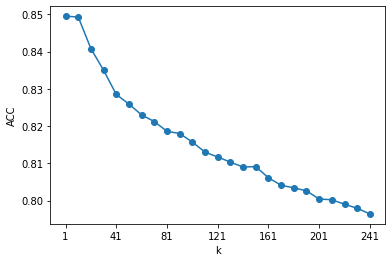

In [19]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot([i*10 + 1 for i in range(25)], k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=range(1, 250, 40))
plt.show()

From the figure, the trend is roughly decending. Therefore, we can choose a range of k in [1, 21]

In [20]:
# Running in arroung 140s

k_value = [i for i in range(1,21)]
k_acc = []

for i in k_value:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 2	 finished.
k = 3	 finished.
k = 4	 finished.
k = 5	 finished.
k = 6	 finished.
k = 7	 finished.
k = 8	 finished.
k = 9	 finished.
k = 10	 finished.
k = 11	 finished.
k = 12	 finished.
k = 13	 finished.
k = 14	 finished.
k = 15	 finished.
k = 16	 finished.
k = 17	 finished.
k = 18	 finished.
k = 19	 finished.
k = 20	 finished.


<Figure size 144x144 with 0 Axes>

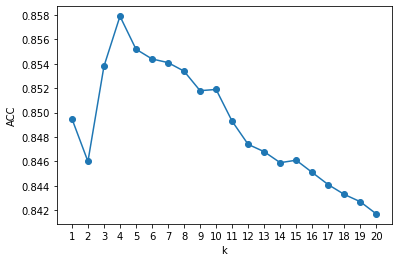

In [21]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot(k_value, k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=k_value)
plt.show()

From the figure above, we chose k = [3, 5, 9]. For p, we chose p [1, 2], it represents manhattan_distance and euclidean_distance respectively. We also consider the weight (uniform, distance) each point contribute to.

If we use CV with 10 folds, totally we need 3 * 2 * 2 * cv = 120 on 90% training set. Considering the running time, we use standard grid search instead.

In [22]:
# Setting parameters
param_grid = {
    'n_neighbors': [3, 5, 9],
    'p': [1, 2],
    "weights": ["uniform", "distance"],
    }

knn_paras = ParameterGrid(param_grid)

print(f"There are {len(list(knn_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

# ----------------------------------------------------------
# CV for tuning
# Setting the 10 fold stratified cross-validation

# cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cvKFold, return_train_score=True, verbose=3)
# grid_search.fit(X_train_full.reshape(60000, -1), y_train_full)

There are 12 combinations.
Parameter grid:
{'n_neighbors': [3, 5, 9], 'p': [1, 2], 'weights': ['uniform', 'distance']}


In [23]:
# Running in around 410s

# Tuning KNN paras, 12 combination in total.
knn_result = get_result(
    KNeighborsClassifier(), 
    knn_paras, 
    X_train=X_train.reshape(X_train.shape[0], -1), 
    X_valid=X_valid.reshape(X_valid.shape[0], -1)
    )

1 out of 12 finished.
2 out of 12 finished.
3 out of 12 finished.
4 out of 12 finished.
5 out of 12 finished.
6 out of 12 finished.
7 out of 12 finished.
8 out of 12 finished.
9 out of 12 finished.
10 out of 12 finished.
11 out of 12 finished.
12 out of 12 finished.


In [24]:
# Running in around 110s

show_results("KNN", knn_result, X_test=X_test.reshape(X_test.shape[0], -1))

Results for KNN:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best validation score: 0.8653
Test set score: 0.8567


,Score,training_time,validation_time
"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.8622,0.08,55.33
"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.8653,0.07,56.74
"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.8583,0.08,3.49
"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.8602,0.06,3.26
"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.8603,0.09,54.26
"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.8622,0.06,54.26
"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.855,0.08,3.46
"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.8577,0.06,3.27
"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.8628,0.09,54.43
"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.8645,0.06,54.62


### 3.2 Fully connected neural network

From section 2.2, we settled the numbers of neurons (100, 20) in hidden layers. Although the number of hidden layers as well as number of neurons are also hyperparameter, to avoid a great running time due to a number of combination of paras, we design the structure first and tune the other paras in this section.

In [6]:
def build_mlp(activation_function="relu"):
    """Build a Keras MLP for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=IMAGE_SIZE))
    
    # Add the hidden layers with activation function
    model.add(keras.layers.Dense(100, activation=activation_function))
    model.add(keras.layers.Dense(20, activation=activation_function))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_mlp,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

param_grid = {
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh", None],
    "optimizer": ["sgd", "Adam"]
}

mlp_paras = ParameterGrid(param_grid)

print(f"There are {len(list(mlp_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

There are 24 combinations.
Parameter grid:
{'optimizer__lr': [0.1, 0.01, 0.001], 'activation_function': ['relu', 'sigmoid', 'tanh', None], 'optimizer': ['sgd', 'Adam']}


In [26]:
# Running in arround 1800s

mlp_result = get_result(keras_classifier, mlp_paras, epochs=30)

Epoch 1/30


c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5828 - accuracy: 0.7866
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4142 - accuracy: 0.8485
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3736 - accuracy: 0.8630
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3474 - accuracy: 0.8719
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3293 - accuracy: 0.8783
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3143 - accuracy: 0.8838
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3031 - accuracy: 0.8888
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2929 - accuracy: 0.8901
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2844 - accuracy: 0.8929
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2797 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.7796 - accuracy: 0.7406
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5088 - accuracy: 0.8235
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4597 - accuracy: 0.8393
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4328 - accuracy: 0.8474
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4132 - accuracy: 0.8544
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3973 - accuracy: 0.8621
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3839 - accuracy: 0.8651
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3732 - accuracy: 0.8683
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3630 - accuracy: 0.8719
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3545 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.7175 - accuracy: 0.4389
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.1015 - accuracy: 0.6524
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8764 - accuracy: 0.6871
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7801 - accuracy: 0.7178
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7221 - accuracy: 0.7439
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6799 - accuracy: 0.7638
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6461 - accuracy: 0.7801
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6173 - accuracy: 0.7913
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5928 - accuracy: 0.8004
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5723 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.5463 - accuracy: 0.3626
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4111 - accuracy: 0.3500
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4844 - accuracy: 0.3378
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7644 - accuracy: 0.2027
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7721 - accuracy: 0.1980
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7944 - accuracy: 0.1972
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7579 - accuracy: 0.1971
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7597 - accuracy: 0.1955
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7586 - accuracy: 0.1962
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7598 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5713 - accuracy: 0.7924
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4413 - accuracy: 0.8406
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4134 - accuracy: 0.8517
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4001 - accuracy: 0.8565
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3873 - accuracy: 0.8620
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3802 - accuracy: 0.8634
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3745 - accuracy: 0.8667
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3611 - accuracy: 0.8721
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3581 - accuracy: 0.8730
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3555 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 1ms/step - loss: 0.5382 - accuracy: 0.8097
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3896 - accuracy: 0.8610
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3496 - accuracy: 0.8723
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3272 - accuracy: 0.8796
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3081 - accuracy: 0.8872
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2947 - accuracy: 0.8913
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2821 - accuracy: 0.8958
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2681 - accuracy: 0.9004
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2612 - accuracy: 0.9018
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2521 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.0409 - accuracy: 0.6619
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5602 - accuracy: 0.8033
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4838 - accuracy: 0.8286
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4451 - accuracy: 0.8401
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4190 - accuracy: 0.8509
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3993 - accuracy: 0.8575
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3844 - accuracy: 0.8624
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3723 - accuracy: 0.8662
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3619 - accuracy: 0.8696
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3533 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.1202 - accuracy: 0.4008
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5601 - accuracy: 0.5391
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2323 - accuracy: 0.6225
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0571 - accuracy: 0.6536
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.9375 - accuracy: 0.6792
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8504 - accuracy: 0.7066
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7833 - accuracy: 0.7283
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7294 - accuracy: 0.7457
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6861 - accuracy: 0.7586
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6514 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.3663 - accuracy: 0.1022
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2771 - accuracy: 0.1301
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2490 - accuracy: 0.3064
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2235 - accuracy: 0.4730
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1958 - accuracy: 0.5137
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1642 - accuracy: 0.5341
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1276 - accuracy: 0.5460
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.0850 - accuracy: 0.5400
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.0364 - accuracy: 0.5472
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9822 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.3249 - accuracy: 0.4316
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2869 - accuracy: 0.4299
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2529 - accuracy: 0.4292
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2044 - accuracy: 0.4476
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.1946 - accuracy: 0.4515
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.1834 - accuracy: 0.4534
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2194 - accuracy: 0.4469
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2136 - accuracy: 0.4518
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2269 - accuracy: 0.4390
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2254 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5861 - accuracy: 0.7915
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4712 - accuracy: 0.8331
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4539 - accuracy: 0.8376
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4466 - accuracy: 0.8425
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4259 - accuracy: 0.8487
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4188 - accuracy: 0.8502
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4138 - accuracy: 0.8517
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4052 - accuracy: 0.8549
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4008 - accuracy: 0.8569
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3955 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.7804 - accuracy: 0.7599
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4225 - accuracy: 0.8533
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3700 - accuracy: 0.8684
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3429 - accuracy: 0.8769
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3233 - accuracy: 0.8839
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3081 - accuracy: 0.8887
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2947 - accuracy: 0.8944
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2819 - accuracy: 0.8981
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2734 - accuracy: 0.9007
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2653 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5473 - accuracy: 0.8043
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4170 - accuracy: 0.8497
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3803 - accuracy: 0.8620
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3568 - accuracy: 0.8708
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3381 - accuracy: 0.8774
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3234 - accuracy: 0.8821
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3111 - accuracy: 0.8863
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3007 - accuracy: 0.8899
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2910 - accuracy: 0.8924
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2830 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.8310 - accuracy: 0.7396
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5300 - accuracy: 0.8211
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4678 - accuracy: 0.8367
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4356 - accuracy: 0.8454
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4147 - accuracy: 0.8535
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3987 - accuracy: 0.8592
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3860 - accuracy: 0.8627
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3757 - accuracy: 0.8671
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3668 - accuracy: 0.8689
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3593 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 1ms/step - loss: 1.4639 - accuracy: 0.5648
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0372 - accuracy: 0.6951
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8926 - accuracy: 0.7314
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8055 - accuracy: 0.7538
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7444 - accuracy: 0.7710
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6973 - accuracy: 0.7837
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6599 - accuracy: 0.7934
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6302 - accuracy: 0.8010
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6061 - accuracy: 0.8073
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5862 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.3502 - accuracy: 0.1391
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5129 - accuracy: 0.0997
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5171 - accuracy: 0.1019
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5099 - accuracy: 0.0981
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5084 - accuracy: 0.1015
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5137 - accuracy: 0.0989
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5011 - accuracy: 0.1010
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5144 - accuracy: 0.1001
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5148 - accuracy: 0.1006
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5081 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6944 - accuracy: 0.7453
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6334 - accuracy: 0.7732
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6133 - accuracy: 0.7851
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6378 - accuracy: 0.7724
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6177 - accuracy: 0.7778
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6392 - accuracy: 0.7663
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.7823
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6050 - accuracy: 0.7881
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5973 - accuracy: 0.7845
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6037 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 0.5129 - accuracy: 0.8242
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3812 - accuracy: 0.8625
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3430 - accuracy: 0.8759
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3236 - accuracy: 0.8812
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3066 - accuracy: 0.8875
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2949 - accuracy: 0.8904
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2807 - accuracy: 0.8961
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2717 - accuracy: 0.8991
Epoch 9/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2652 - accuracy: 0.9009
Epoch 10/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2583 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 0.6106 - accuracy: 0.7877
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4882 - accuracy: 0.8289
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4664 - accuracy: 0.8378
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4559 - accuracy: 0.8395
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4473 - accuracy: 0.8438
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4409 - accuracy: 0.8477
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4353 - accuracy: 0.8481
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4338 - accuracy: 0.8482
Epoch 9/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4286 - accuracy: 0.8504
Epoch 10/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4273 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 0.6849 - accuracy: 0.7664
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5021 - accuracy: 0.8273
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4682 - accuracy: 0.8374
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4515 - accuracy: 0.8408
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4401 - accuracy: 0.8474
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4318 - accuracy: 0.8506
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4257 - accuracy: 0.8522
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4208 - accuracy: 0.8540
Epoch 9/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4163 - accuracy: 0.8548
Epoch 10/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4133 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 1.2039 - accuracy: 0.6052
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.7999 - accuracy: 0.7228
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.7025 - accuracy: 0.7583
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6475 - accuracy: 0.7784
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6109 - accuracy: 0.7930
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5838 - accuracy: 0.8023
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5632 - accuracy: 0.8100
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5464 - accuracy: 0.8150
Epoch 9/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5328 - accuracy: 0.8193
Epoch 10/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5216 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 229.7746 - accuracy: 0.7259
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 33.0447 - accuracy: 0.7429
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 6.8981 - accuracy: 0.7438
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 320.1916 - accuracy: 0.7269
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 38.8116 - accuracy: 0.7514
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 12.9391 - accuracy: 0.7413
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 369.7435 - accuracy: 0.7158
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 27.4467 - accuracy: 0.7638
Epoch 9/30
1688/1688 [==============================] - 3s 2ms/step - loss: 16.3582 - accuracy: 0.7440
Epoch 10/30
1688/1688 [==============================] - 3s 2ms/step - loss: 395.8

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 0.6639 - accuracy: 0.7843
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5769 - accuracy: 0.8064
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5539 - accuracy: 0.8126
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5460 - accuracy: 0.8163
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5544 - accuracy: 0.8166
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5438 - accuracy: 0.8208
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5364 - accuracy: 0.8216
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5471 - accuracy: 0.8224
Epoch 9/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5088 - accuracy: 0.8287
Epoch 10/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5667 - accurac

c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 2ms/step - loss: 0.5570 - accuracy: 0.8055
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4662 - accuracy: 0.8362
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4464 - accuracy: 0.8443
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4363 - accuracy: 0.8466
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4297 - accuracy: 0.8497
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4222 - accuracy: 0.8523
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4182 - accuracy: 0.8526
Epoch 8/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4111 - accuracy: 0.8558
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4085 - accuracy: 0.8555
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4090 - accurac

In [27]:
show_results("MLP", mlp_result)

Results for MLP:
Best parameters: {'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.001}
Best validation score: 0.8933
313/313 [==============================] - 0s 869us/step
Test set score: 0.8850


,Score,training_time,validation_time
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.1}",0.8733,60.99,0.34
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.01}",0.8835,59.75,0.29
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.001}",0.8468,58.45,0.29
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.1}",0.197,60.95,0.28
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.01}",0.8617,145.03,0.31
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001}",0.8928,69.17,0.32
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.1}",0.8803,60.62,0.31
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.01}",0.8418,61.28,0.31
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.001}",0.6603,62.96,0.32
"{'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.1}",0.3617,67.84,0.31


From the table above, both {'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001} and {'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.001} are good. Considering the limitations of Sigmoid activation function, we choose **ReLU** in this study.

Then we observe the trend of epochs with these paras.

In [15]:
# build a model with paras we just chose
mlp_model = build_mlp(activation_function="relu")

mlp_model.summary()

mlp_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               78500     
                                                                 
 dense_25 (Dense)            (None, 20)                2020      
                                                                 
 dense_26 (Dense)            (None, 10)                210       
                                                                 
Total params: 80,730
Trainable params: 80,730
Non-trainable params: 0
_________________________________________________________________


In [22]:
mlp_history = mlp_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0984 - accuracy: 0.9628 - val_loss: 0.4898 - val_accuracy: 0.8860
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0988 - accuracy: 0.9640 - val_loss: 0.5211 - val_accuracy: 0.8898
Epoch 3/30
 899/1688 [==============>...............] - ETA: 0s - loss: 0.0904 - accuracy: 0.9667

KeyboardInterrupt: 

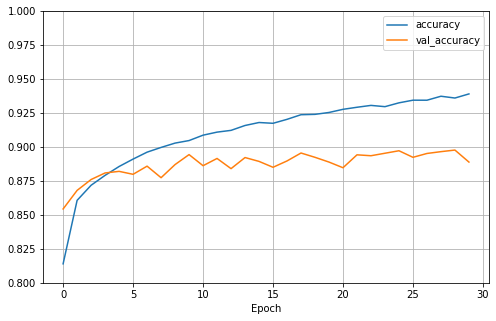

In [17]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

The accuracy of validation set fluctuated since epoch = 10, thus, we set the epochs = 10 to keep it small.

### Convolutional neural network

## 4. Final models

### 4.1 K-nearest neighbors

Best paras for K-nearest neighbors is:  
'n_neighbors'= 3, 'p'= 1, 'weights'= 'distance'.

In [28]:
# Set the best paras
knn_best_paras = dict({'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

knn = KNeighborsClassifier(**knn_best_paras)
knn_runtime = time.time()
knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
knn_runtime = time.time - knn_runtime

KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [29]:
# Running in around 120s

# Performance on test set.
print(f"KNN training time: {knn_runtime:.2f} s")
print(f"KNN score on the test set: {knn.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}")

KNN score on the test set: 0.8597


### 4.2 Fully connected neural network

We settled the size of layers (784, 100, 20, 10) in section 2.2; and settled the the best paras of our experimental settings:   
'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001   
epochs: 10

In [7]:
# Running in around 25s

keras.backend.clear_session()

# Build the final model
mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=IMAGE_SIZE),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# mlp.summary()

# Complie the model
mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
mlp_runtime = time.time()
mlp.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=1)
mlp_runtime = time.time() - mlp_runtime

Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5286 - accuracy: 0.8144 - val_loss: 0.3980 - val_accuracy: 0.8595
Epoch 2/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3896 - accuracy: 0.8607 - val_loss: 0.3539 - val_accuracy: 0.8732
Epoch 3/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3507 - accuracy: 0.8726 - val_loss: 0.3427 - val_accuracy: 0.8762
Epoch 4/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3293 - accuracy: 0.8808 - val_loss: 0.3214 - val_accuracy: 0.8792
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3096 - accuracy: 0.8865 - val_loss: 0.3266 - val_accuracy: 0.8782
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2965 - accuracy: 0.8909 - val_loss: 0.3249 - val_accuracy: 0.8803
Epoch 7/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2823 - accuracy: 0.8956 - val_loss: 0.3115 - val_accuracy:

In [8]:
# Performance on test set.
loss, accuracy = mlp.evaluate(X_test, y_test)
print(f"MLP training time: {mlp_runtime:.2f} s")
print(f"MLP score on the test set: {accuracy:.4f}")


313/313 [==============================] - 0s 1ms/step - loss: 0.3315 - accuracy: 0.8824
MLP runtime: 24.77 s
MLP score on the test set: 0.8824


### Convolutional neural network